In [1]:
import os
from argparse import ArgumentParser
from collections import OrderedDict

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import torchvision.utils as vutils
from torchvision.datasets import MNIST
import pytorch_lightning as pl
from matplotlib import pyplot as plt


# DATALOADER

In [2]:
class MNISTDataModule(pl.LightningDataModule):

    def __init__(self, data_dir: str = './', batch_size: int = 128, num_workers: int = 16):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers

        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize(64),
            transforms.CenterCrop(64),
            transforms.Normalize((0.5,), (0.5,))
        ])

        # self.dims is returned when you call dm.size()
        # Setting default dims here because we know them.
        # Could optionally be assigned dynamically in dm.setup()
        self.dims = (1, 64, 64)
        self.num_classes = 10

    def prepare_data(self):
        # download
        MNIST(self.data_dir, train=True, download=True)
        MNIST(self.data_dir, train=False, download=True)

    def setup(self, stage=None):

        # Assign train/val datasets for use in dataloaders
        if stage == 'fit' or stage is None:
            mnist_full = MNIST(self.data_dir, train=True, transform=self.transform)
            self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])

        # Assign test dataset for use in dataloader(s)
        if stage == 'test' or stage is None:
            self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.mnist_train, batch_size=self.batch_size, num_workers=self.num_workers, pin_memory=True)

    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=self.batch_size, num_workers=self.num_workers,pin_memory=True)

    def test_dataloader(self):
        return DataLoader(self.mnist_test, batch_size=self.batch_size, num_workers=self.num_workers,pin_memory=True)

# Generator Model

In [3]:
class Generator(nn.Module):
    def __init__(self, latent_dim, img_shape):
        super().__init__()
        self.img_shape = img_shape
        def _block(in_channels, out_channels, kernel_size, stride, padding):
            return nn.Sequential(
                nn.ConvTranspose2d(
                    in_channels,
                    out_channels,
                    kernel_size,
                    stride,
                    padding,
                    bias=False,
                ),
                #nn.BatchNorm2d(out_channels),
                nn.ReLU(),
            )
        self.model = nn.Sequential(
            # Input: N x channels_noise x 1 x 1
            *_block(latent_dim, img_shape[1] * 16, 4, 1, 0),  # img: 4x4
            *_block(img_shape[1] * 16, img_shape[1] * 8, 4, 2, 1),  # img: 8x8
            *_block(img_shape[1] * 8, img_shape[1] * 4, 4, 2, 1),  # img: 16x16
            *_block(img_shape[1] * 4, img_shape[1] * 2, 4, 2, 1),  # img: 32x32
            nn.ConvTranspose2d(
                img_shape[1] * 2, 1, kernel_size=4, stride=2, padding=1
            ),
            # Output: N x channels_img x 64 x 64
            nn.Tanh(),
        )
        
        
    def forward(self, z):
        img = self.model(z)
        return img
    



# Discriminator Model

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, img_shape):
        super().__init__()
        
        def _block( in_channels, out_channels, kernel_size, stride, padding):
                    return nn.Sequential(
                        nn.Conv2d(
                            in_channels,
                            out_channels,
                            kernel_size,
                            stride,
                            padding,
                            bias=False,
                        ),
                        nn.InstanceNorm2d(out_channels, affine=True),
                        nn.LeakyReLU(0.2),
                    )
        self.model = nn.Sequential(
            # input: N x channels_img x 64 x 64
            nn.Conv2d(
                1, img_shape[1], kernel_size=4, stride=2, padding=1
            ),
            nn.LeakyReLU(0.2),
            # _block(in_channels, out_channels, kernel_size, stride, padding)
            *_block(img_shape[1], img_shape[1] * 2, 4, 2, 1),
            *_block(img_shape[1] * 2, img_shape[1] * 4, 4, 2, 1),
            *_block(img_shape[1] * 4, img_shape[1] * 8, 4, 2, 1),
            # After all _block img output is 4x4 (Conv2d below makes into 1x1)
            nn.Conv2d(img_shape[1] * 8, 1, kernel_size=4, stride=2, padding=0),
        )

            
    def forward(self, img):
        out=self.model(img).view(-1,1)
        return out
    



# GAN MODEL

In [4]:
 class GAN(pl.LightningModule):

    def __init__(
        self,
        channels,
        width,
        height,
        latent_dim: int = 100,
        lr: float =0.00005, 
        b1: float = 0.5,
        b2: float = 0.999,
        batch_size: int = 128,
        weight_clip: int=0.01,
        critic_iterations: int=5,
        **kwargs
    ):
        super().__init__()
        self.save_hyperparameters()

        # networks
        data_shape = (channels, width, height)
        self.generator = Generator(latent_dim=self.hparams.latent_dim, img_shape=data_shape )
        self.critic = Discriminator(img_shape=data_shape)

        self.validation_z = torch.randn(8, self.hparams.latent_dim,1, 1)

        self.example_input_array = torch.zeros(2, self.hparams.latent_dim,1, 1)
        
        
    def forward(self, z):
        return self.generator(z)

    def adversarial_loss(self, y_hat, y):
         return 
        #return F.binary_cross_entropy(y_hat, y)
        
    
    def training_step(self, batch, batch_idx, optimizer_idx):
        imgs, _ = batch
        (opt_g, opt_d) = self.optimizers()

        # sample noise
        z = torch.randn(imgs.shape[0], 100,1, 1)
        z = z.type_as(imgs)

        # train generator
        #if optimizer_idx == 0:
        # generate images
        self.generated_imgs = self(z)

        # log sampled images
        sample_imgs = self.generated_imgs[:6]
        grid = torchvision.utils.make_grid(sample_imgs,padding=2, normalize=True)
        self.logger.experiment.add_image('generated_images', grid, 0)

        # ground truth result (ie: all fake)
        # put on GPU because we created this tensor inside training_loop
        valid = torch.ones(imgs.size(0), 1)
        valid = valid.type_as(imgs)

        # adversarial loss is binary cross-entropy
        #g_loss = self.(self.discriminator(self(z)), valid)
            
        gen_fake = self.critic(self(z)).reshape(-1)

        g_loss=-torch.mean(gen_fake)
        self.generator.zero_grad()
        self.manual_backward(g_loss,opt_g)
        opt_g.step()
        '''
            tqdm_dict = {'g_loss': g_loss}
            output = OrderedDict({
                'loss': g_loss,
                'progress_bar': tqdm_dict,
                'log': tqdm_dict
            })
        '''
        #return output
            
        
        # train discriminator
        #if optimizer_idx == 1:
            # Measure discriminator's ability to classify real from generated samples
        for _ in range(self.hparams.critic_iterations):
            z = torch.randn(imgs.shape[0], 100,1, 1)
            z = z.type_as(imgs)
                
            # how well can it label as real?
            valid = torch.ones(imgs.size(0), 1)
            valid = valid.type_as(imgs)
                
            fake=self(z)
            critic_real=self.critic(imgs).reshape(-1)
            critic_fake = self.critic(fake).reshape(-1)
        
            loss_critic=-(torch.mean(critic_real)-torch.mean(critic_fake))
            self.critic.zero_grad()
                
            self.manual_backward(loss_critic,opt_d, retain_graph=True)
            opt_d.step()


                
            for p in self.critic.parameters():
                p.data.clamp_(-self.hparams.weight_clip, self.hparams.weight_clip)
                    
            
        self.log('g_loss', g_loss, prog_bar=True,)      
        self.log('loss_critic', loss_critic, prog_bar=True)

        
    def configure_optimizers(self):
        lr = self.hparams.lr
        b1 = self.hparams.b1
        b2 = self.hparams.b2
        opt_g = torch.optim.RMSprop(self.generator.parameters(), lr=lr)
        opt_d = torch.optim.RMSprop(self.critic.parameters(), lr=lr)
        return [opt_g, opt_d], []
    
    

    
    def on_epoch_end(self):
        z = self.validation_z.type_as(self.generator.model[0].weight)
        # log sampled images
        sample_imgs = self(z)
        grid = torchvision.utils.make_grid(sample_imgs,padding=2, normalize=True)
        self.logger.experiment.add_image('generated_images', grid, self.current_epoch)
           

In [5]:

dm = MNISTDataModule()
dm.size()

(1, 64, 64)

In [6]:
model = GAN(*dm.size())
model.generator

Generator(
  (model): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): ReLU()
    (2): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): ReLU()
    (4): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (5): ReLU()
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): ReLU()
    (8): ConvTranspose2d(128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): Tanh()
  )
)

In [7]:
model.critic

Discriminator(
  (model): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(2, 2))
  )
)

# test output network

In [8]:
N, in_channels, H, W = 8, 1, 64, 64
noise_dim = 100
x = torch.randn((N, in_channels, H, W))
disc = model.critic(x)
print("disc: "+str(disc.size()))
z = torch.randn((N, noise_dim, 1, 1))
gen=model(z)#.squeeze(1)
print(str(gen.size()))


disc: torch.Size([8, 1])
torch.Size([8, 1, 64, 64])


 # test Generator ouput
 

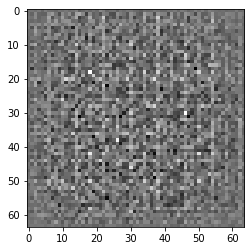

In [9]:
xx=gen.data.cpu().numpy().squeeze(1)
plt.imshow(xx[0],cmap='gray')
plt.show()

# test Discriminator output

In [10]:
fake = torch.zeros(8, 1)
critic_fake = model.critic(gen).reshape(-1)
loss_critic=-(torch.mean(critic_fake)-torch.mean(fake))


print(str(loss_critic.reshape(-1)))


tensor([-0.3303], grad_fn=<ViewBackward>)



# Trainer

In [ ]:
trainer = pl.Trainer(gpus=-1, max_epochs=5,automatic_optimization=False, accelerator='dp')
trainer.fit(model, dm)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name      | Type          | Params | In sizes       | Out sizes     
------------------------------------------------------------------------------
0 | generator | Generator     | 12.7 M | [2, 100, 1, 1] | [2, 1, 64, 64]
1 | critic    | Discriminator | 2.8 M  | ?              | ?             
------------------------------------------------------------------------------
15.4 M    Trainable params
0         Non-trainable params
15.4 M    Total params


Epoch 0:   0%|          | 0/430 [00:00<?, ?it/s] 

/home/cal/anaconda3/envs/pytorch/lib/python3.8/site-packages/torch/nn/modules/module.py:1325: UserWarning: Calling .zero_grad() from a module created with nn.DataParallel() has no effect. The parameters are copied (in a differentiable manner) from the original module. This means they are not leaf nodes in autograd and so don't accumulate gradients. If you need gradients in your forward method, consider using autograd.grad instead.
  warnings.warn(
/home/cal/anaconda3/envs/pytorch/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: Your training_step returned None. Make sure that was your intention!
  warnings.warn(*args, **kwargs)


Epoch 2:  47%|████▋     | 201/430 [01:05<01:14,  3.05it/s, v_num=3, g_loss=-.312, loss_critic=-.489]

# Test 

In [ ]:
# Start tensorboard.+
#%load_ext tensorboard
#%tensorboard --logdir lightning_logs/   --host localhost 

In [ ]:
z = torch.randn((N, noise_dim, 1, 1))
gen=model(z).squeeze(1)
xx=gen.data.cpu().numpy()
plt.imshow(xx[0],cmap='gray')
plt.show()

sample_imgs =model(z)
grid = torchvision.utils.make_grid(sample_imgs,padding=2, normalize=True)
npimg = grid.detach().numpy()
plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
plt.show()

